In [46]:
# Imports
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import datetime


#Settings
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 101)

# Task Description

Case description:
Welcome to East Carmen Airlines! As a strategic data scientist, you are confronted with many use cases to digitalize the airline business. Most important for airlines are accurate predictions of flight arrivals during a day of operations. When it comes to passenger handling, such predictions would admit a proactive steering, in order that the passengers reach the connection flights and therefore save a lot of money.

Your model should be applicable to each aircraft in East Carmen’s fleet. Let us take as an example the aircraft with registration name EC-LPD. At scheduled departure of the earliest morning flight from East Carmen’s hub Madrid the model should predict all flights of EC-LPD on the given day.

Many business stakeholders do not trust in the robustness of such a model. They claim that for a given aircraft, one could predict the first flight of the day with a decent error, but the errors of second and third flights will be huge. It is now your task to convince the business stakeholders that with a well-prepared data set and meaningful features you can deliver robust flight predictions.

Project Aim:
From different departments business analysts have collected a lot of information on possible features for flight predictions. Now it is your task to use these data to deliver a prototype forecasting model for all flights of a given aircraft at scheduled departure of the first flight of the day. 

For instance, for an aircraft with registration name EC-LPD, first flight of the day (FFOD) scheduled at 5:30 am from MAD to VIE and with the connection chain MAD-VIE-MAD-CDG-MAD-LHR-MAD your model should predict the successive landing times in VIE, MAD, CDG, MAD, LHR, MAD. The colleagues from daily operations are especially interested in how the confidence level of such a model evolves during a day of operations.

# General Information
| Amendments by me


3.1 File Names
- zip-folder: use_case_3.zip
- flight_information.csv : information on flights in a given time period, where each data point is a so-called 
leg, i.e. a flight from departure airport to destination airport with all relevant flight and crew information
- ground_information.csv : information on the ground processes after landing at our hub “East Carmen”,
where each data point describes the processes between two flights (inbound = landing, outbound = takeoff).


3.2 Column Description – Flight Information
- leg_no: unique identifier of a flight on a given day, at a certain time, with a given flight number
- fn_carrier: airline name
- fn_number: flight number; has to be unique on a given day
- dep_ap_sched: scheduled departure airport
- arr_ap_sched: scheduled arrival airport
- dep_sched_date: scheduled departure date
- dep_sched_time: scheduled departure time
- arr_sched_date: scheduled arrival date
- arr_sched_time: scheduled arrival time
- m_offblockdt: timestamp of departure
- m_onblockdt: timestamp of arrival
- ac_registration: aircraft registration number, i.e. the “license plate” of the aircraft
- change_reason_code: reason for delay (assigned after the flight)
- dep_delay: departure delay
- Ac Type Code: aircraft type (example: 320 = Airbus A320)
- trans_time: true minimal transition time for crew members after flight, i.e. transition time of the crew
member with the least time
- sched_trans_time: scheduled minimal transition time for crew members after flight, i.e. scheduled transition
time of the crew member with the least time
4
- Crew Group: assignment of what happens to the whole crew after a flight
o Start : First flight of day
o A : all crew members stay on the aircraft for the next flight
o B, B2: all crew members switch aircraft for the next flight
o C: at least one crew member switches aircraft for the next flight
- TLC_trans: names of crew members on flight with some additional information attached to each name (but business does not know exactly which additional information is visible there)
- crew_type_change: rank (cp = pilot, ca = cabin member) of crew members, who changed aircraft
- Sched Groundtime: scheduled ground time of the aircraft between flights | has mistakes; mostly (dep_sched_time of next line) - (arr_sched_time of current line); groundtime AFTER landing
- Act Groundtime: actual ground time of the aircraft between flights | has mistakes; mostly (m_offblocktime of next line) - (m_onblocktime of current line); groundtime AFTER landing


3.3 Column Description – Ground Information
- Each datapoint consists of an inbound (=arriving) flight and an outbound (=departing) flight from our hub “East Carmen)
- Catering, cleaning and pax (=passenger) boarding durations given for our hub “East Carmen” between the inbound and outbound flights
- day_of_origin: day of flight (also given in Flight Information)
- ac_type: aircraft type (also given in Flight Information)
- fn_number: flight number (also given in Flight Information)
- ac_registration: aircraft registration (also given in Flight Information)
- mingt: minimal scheduled ground time for the given aircraft
- dep_leg_inbound: departure airport name of inbound (=arriving) flight
- arr_leg_inbound: arrival airport name of inbound (=arriving) flight
- arr_leg_outbound: departure airport name of outbound (=departing) flight
- sched_inbound_dep: scheduled departure time of inbound (=arriving) flight
- sched_inbound_arr: scheduled arrival time of inbound (=arriving) flight
- sched_outbound_dep: scheduled departure time of outbound (=departing) flight
- sched_outbound_arr: scheduled arrival time of outbound (=departing) flight
- sched_turnaround: scheduled ground time for aircraft
- leg_inbound: leg number of inbound flight
- leg_outbound: leg number of outbound flight
- catering_duration: catering duration (i.e. filling up meal boxes) between flights in minutes
- cleaning_duration: cleaning duration between flights in minutes
- pax_boarding_duration: boarding duration between flights in minutes


3.4 Additional Info from Business Side:
- BI (=business intelligence) colleagues have collected a lot of flight information from many different de-partments: flight-, crew- and ground operations. Each department uses a different data warehouse. BI colleagues claim that some of the columns might be redundant and some information could be wrong, due to bad and not consistent data in the different data warehouses of the business departments. It is central for this prototype study to clean and transform the data and make consistency checks, before applying a machine learning algorithm.

# Initial Dataset Structure

In [47]:
# some general functions

def na_count(flt_info):
    '''Takes a Pandas dataframe as input and returns NA-Values per attribute.'''
    for attribute in flt_info.columns:
        print(str(attribute) + " NAs: " + str(flt_info[attribute].isna().sum()) + "(" + str(round(flt_info[attribute].isna().sum() / flt_info[attribute].count() *100, 2)) + "%)" )



In [48]:
# Read files 

flt_info = pd.read_csv('../data/raw/flight_information.csv', index_col = 0)
ground_info = pd.read_csv('../data/raw/ground_information.csv', index_col = 0)

# Variable type conversions

data_type_dict_flt_info = {
    'm_offblockdt' : 'datetime64',
    'm_onblockdt' : 'datetime64',
    'arr_sched_time' : 'datetime64',
    'dep_sched_time' : 'datetime64',
    'dep_sched_date' : 'datetime64',
    'arr_sched_date' : 'datetime64',
    
    
#    'fn_carrier' : 'category',
#    'fn_number' : 'category',
#    'dep_ap_sched' : 'category',
#    'arr_ap_sched' : 'category',
#    'ac_registration' : 'category',
#    'ac_registration' : 'category',


}

data_type_dict_ground_info = {
    'day_of_origin' : 'datetime64',
    'sched_inbound_dep' : 'datetime64',
    'sched_inbound_arr' : 'datetime64',
    'sched_outbound_dep' : 'datetime64',
    'sched_outbound_arr' : 'datetime64',
}

flt_info = flt_info.astype(data_type_dict_flt_info)
ground_info = ground_info.astype(data_type_dict_ground_info)

# calculate block time 
flt_info["block_time"] = flt_info['m_onblockdt']-flt_info['m_offblockdt']
# Convert to minutes
flt_info["block_time"] = flt_info["block_time"].dt.total_seconds()/60


# Add routing column 
flt_info['leg'] = flt_info["dep_ap_sched"] + "-" + flt_info["arr_ap_sched"]
flt_info['route'] = np.where(flt_info["dep_ap_sched"]<flt_info["arr_ap_sched"], 
    flt_info["dep_ap_sched"] + "-" + flt_info["arr_ap_sched"],
    flt_info["arr_ap_sched"] + "-" + flt_info["dep_ap_sched"]
    )

flt_info


,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,block_time,leg,route
0,272005011,East Carmen Airlines,EC3098,North Gregory,East Carmen,2019-06-01,2022-04-30 00:40:00,2019-06-01,2022-04-30 04:30:00,2019-06-01 00:43:00,2019-06-01 04:12:00,ECLBSX,other problem,3.0,320,0,0,Start,"['Jason Brown_nan_nan_nan_cp', 'Jacob Stein_na...",[],235.0,268.0,209.0,North Gregory-East Carmen,East Carmen-North Gregory
1,272009188,East Carmen Airlines,EC3146,Port Bobby,East Carmen,2019-06-01,2022-04-30 02:05:00,2019-06-01,2022-04-30 04:00:00,2019-06-01 01:58:00,2019-06-01 03:40:00,ECLWHX,no reason,-7.0,E95,0,0,Start,"['Scott Baker_nan_nan_nan_cp', 'Ruth Hoffman_n...",[],130.0,189.0,102.0,Port Bobby-East Carmen,East Carmen-Port Bobby
2,271984537,East Carmen Airlines,EC2840,Port Ryan,East Carmen,2019-06-01,2022-04-30 02:20:00,2019-06-01,2022-04-30 03:50:00,2019-06-01 02:24:00,2019-06-01 03:57:00,ECLGLX,other problem,4.0,DH4,0,0,Start,"['Cory Cooper_nan_nan_nan_ca', 'Morgan Foster_...",[],185.0,196.0,93.0,Port Ryan-East Carmen,East Carmen-Port Ryan
3,272025831,East Carmen Airlines,EC3306,Coleland,East Carmen,2019-06-01,2022-04-30 02:25:00,2019-06-01,2022-04-30 04:00:00,2019-06-01 02:28:00,2019-06-01 03:49:00,ECLBMX,other problem,3.0,320,0,0,Start,"['Anne Davis_nan_nan_nan_ca', 'Miss Amanda Har...",[],145.0,175.0,81.0,Coleland-East Carmen,Coleland-East Carmen
4,272006092,East Carmen Airlines,EC3114,East Melissaberg,East Carmen,2019-06-01,2022-04-30 02:30:00,2019-06-01,2022-04-30 04:15:00,2019-06-01 03:02:00,2019-06-01 04:43:00,ECLGNX,other problem,32.0,DH4,0,0,Start,"['Renee Fisher_nan_nan_nan_ca', 'Rebecca Castr...",[],35.0,21.0,101.0,East Melissaberg-East Carmen,East Carmen-East Melissaberg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12012,272033556,East Carmen Airlines,EC3399,East Carmen,Port Courtneytown,2019-06-30,2022-04-30 20:45:00,2019-06-30,2022-04-30 21:25:00,2019-06-30 20:59:00,2019-06-30 21:46:00,ECLGJX,other problem,14.0,DH4,27,35,A,"['Derek Sweeney_372_27_35_cp', 'John Hardin_37...",[],NaN,NaN,47.0,East Carmen-Port Courtneytown,East Carmen-Port Courtneytown
12013,272035064,East Carmen Airlines,EC3431,East Carmen,East Allisontown,2019-06-30,2022-04-30 20:45:00,2019-06-30,2022-04-30 21:20:00,2019-06-30 21:02:00,2019-06-30 21:46:00,ECLWJX,technical problem,17.0,E95,38,80,A,"['Linda Davidson_355_38_80_cp', 'Lisa Wilson_3...",[],NaN,NaN,44.0,East Carmen-East Allisontown,East Allisontown-East Carmen
12014,272003336,East Carmen Airlines,EC3077,East Carmen,Lake David,2019-06-30,2022-04-30 21:10:00,2019-06-30,2022-04-30 23:05:00,2019-06-30 21:27:00,2019-06-30 23:37:00,ECLGHX,other problem,17.0,DH4,0,0,Start,"['Andre Leblanc_nan_nan_nan_cp', 'Ronald Shaff...",[],NaN,NaN,130.0,East Carmen-Lake David,East Carmen-Lake David
12015,272025131,East Carmen Airlines,EC3299,East Carmen,Coleland,2019-06-30,2022-04-30 21:15:00,2019-06-30,2022-04-30 22:50:00,2019-06-30 21:35:00,2019-06-30 23:00:00,ECLBFX,other problem,20.0,320,0,0,Start,"['Paul Murray_nan_nan_nan_ca', 'James Lee_nan_...",[],NaN,NaN,85.0,East Carmen-Coleland,Coleland-East Carmen


# Dataset Analysis

In [49]:
# Joining Datasets

full_df = pd.merge(flt_info, ground_info, left_on = ['fn_number', 'dep_sched_date'], right_on = ['fn_number','day_of_origin'], how = 'left')
full_df.head()

# We save the full unedited dataset

full_df_unedited = full_df
full_df_unedited.to_csv('../data/interim/full_df_unedited.csv')
full_df_unedited.to_pickle('../data/interim/full_df_unedited.pkl')


In [20]:
# Count of rows and columns of our data set
full_df.shape

(12185, 42)

### Duplicate Removal

In [21]:
# We exclude complete data dupes and save them for later analysis

dupes = full_df[full_df.duplicated()]
dupes.to_csv('../data/interim/duplicates.csv')
full_df = full_df.drop_duplicates()
full_df.shape

(12069, 42)

Unique values per categorical feature

<AxesSubplot:title={'center':'Unique values per feature'}>

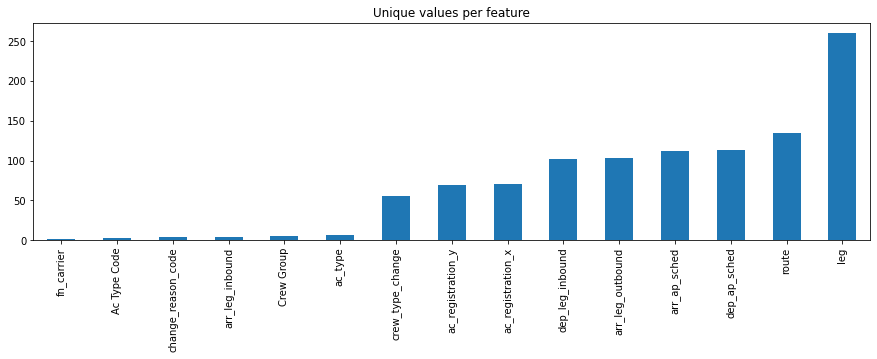

In [22]:
unique_values = full_df.select_dtypes(include = 'object').nunique().sort_values().drop(['TLC_trans', 'fn_number'])

#plot
unique_values.plot.bar(figsize = (15,4), title = "Unique values per feature")

### NaN Analysis

We focus on flt_info first as this is our main data frame

In [23]:
# Count the number of NAs per variable
na_count(flt_info)

flt_info.describe()

leg_no NAs: 0(0.0%)
fn_carrier NAs: 0(0.0%)
fn_number NAs: 0(0.0%)
dep_ap_sched NAs: 0(0.0%)
arr_ap_sched NAs: 0(0.0%)
dep_sched_date NAs: 0(0.0%)
dep_sched_time NAs: 0(0.0%)
arr_sched_date NAs: 0(0.0%)
arr_sched_time NAs: 0(0.0%)
m_offblockdt NAs: 0(0.0%)
m_onblockdt NAs: 83(0.7%)
ac_registration NAs: 0(0.0%)
change_reason_code NAs: 0(0.0%)
dep_delay NAs: 0(0.0%)
Ac Type Code NAs: 0(0.0%)
trans_time NAs: 0(0.0%)
sched_trans_time NAs: 0(0.0%)
Crew Group NAs: 0(0.0%)
TLC_trans NAs: 0(0.0%)
crew_type_change NAs: 0(0.0%)
Sched Groundtime NAs: 2013(20.12%)
Act Groundtime NAs: 2075(20.87%)
block_time NAs: 83(0.7%)
leg NAs: 0(0.0%)
route NAs: 0(0.0%)


,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,block_time
count,1.201700e+04,12017.000000,12017.000000,12017.000000,10004.000000,9942.000000,11934.000000
mean,2.720514e+08,25.782558,27.725139,34.985021,62.837865,66.549789,94.795039
std,9.583346e+04,25.641251,31.900547,31.507227,56.174341,70.686529,41.624100
min,2.719556e+08,-14.000000,-134.000000,0.000000,-245.000000,-383.000000,28.000000
25%,2.719825e+08,9.000000,0.000000,0.000000,45.000000,33.000000,68.000000
50%,2.720115e+08,17.000000,28.000000,45.000000,50.000000,60.000000,86.000000
75%,2.721016e+08,34.000000,49.000000,50.000000,65.000000,87.000000,110.000000
max,2.723603e+08,476.000000,470.000000,495.000000,945.000000,947.000000,333.000000


<AxesSubplot:>

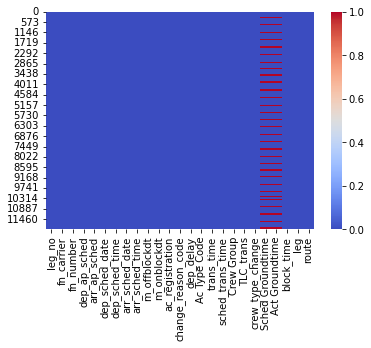

In [24]:
sns.heatmap(flt_info.isnull(), cmap='coolwarm')

Assumption: If m_onblockdt is NA, the flight did not depart to its flight and the flight was cancelled. The row can therefore be removed, we lose 83 observations by doing so (see above)

In [25]:
# THIS ASSUMPTION IS PROBABLY WRONG AND CAUSES ROTATIONAL MISTAKES LATER ON
# MAYBE REMOVE AFTER YOU CHECK FOR ROTATIONAL MISTAKES
# all of them are dupe leg_nos anyways. However, if we remove these NAs, we should do so before fixing the leg_nos

# Removal of NA rows in m_onblockdt. 
#flt_info = flt_info.dropna(subset = ['m_onblockdt'])

# saving intermediate df
#flt_info_1_removed_onblockdt_na = flt_info
#flt_info_1_removed_onblockdt_na.to_csv(
#    path_or_buf = '../data/interim/flt_info_1_removed_onblockdt_na.csv')

In [26]:
flt_info.shape

(12017, 25)

TH1: If Sched Groundtime is NA, Act Groundtime is also NA --> True. Act Groundtime also has more NAs than Sched Groundtime. See H3


<AxesSubplot:>

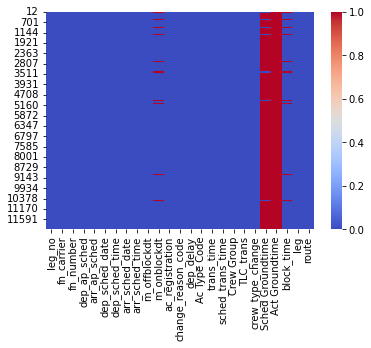

In [27]:
#Hypothesis 1:
flt_info_NA = flt_info[flt_info.isna().any(axis = 1)]
sns.heatmap(flt_info_NA.isnull(), cmap='coolwarm')

In [28]:
flt_info_NA.describe()
# Whenever there is a line with a NA value, Act Groundtime has NA. 

,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,block_time
count,2.075000e+03,2075.00000,2075.000000,2075.000000,62.000000,0.0,1992.000000
mean,2.720475e+08,13.17253,27.721928,40.074699,55.403226,NaN,98.831325
std,9.347359e+04,9.38464,32.967727,31.220075,42.031393,NaN,47.421602
min,2.719565e+08,0.00000,-110.000000,0.000000,-115.000000,NaN,28.000000
25%,2.719814e+08,3.00000,0.000000,0.000000,45.000000,NaN,68.000000
50%,2.720063e+08,15.00000,28.000000,45.000000,45.000000,NaN,89.000000
75%,2.721005e+08,19.00000,51.000000,55.000000,53.750000,NaN,115.000000
max,2.723603e+08,85.00000,228.000000,330.000000,200.000000,NaN,303.000000


H2: Last flight of the day has no value for Sched Groundtime and Act Groundtime

In [29]:
#analysis for single registration and dep day
flt_info[(flt_info['ac_registration'] == 'ECLWHX') & (flt_info['dep_sched_date'] == "2019-06-14")]

,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,block_time,leg,route
5243,271994247,East Carmen Airlines,EC2984,East Holly,East Carmen,2019-06-14,2022-04-30 05:25:00,2019-06-14,2022-04-30 06:30:00,2019-06-14 05:25:00,2019-06-14 06:33:00,ECLWHX,no reason,0.0,E95,0,0,Start,"['Robert Holland_nan_nan_nan_ca', 'Brian Steve...",[],80.0,97.0,68.0,East Holly-East Carmen,East Carmen-East Holly
5287,272002947,East Carmen Airlines,EC3075,East Carmen,Lake David,2019-06-14,2022-04-30 07:50:00,2019-06-14,2022-04-30 09:40:00,2019-06-14 08:10:00,2019-06-14 10:12:00,ECLWHX,other problem,20.0,E95,30,40,B,"['Janet Walls_31_30_40_cp', 'Melissa Walker_31...",[],55.0,35.0,122.0,East Carmen-Lake David,East Carmen-Lake David
5360,272003149,East Carmen Airlines,EC3076,Lake David,East Carmen,2019-06-14,2022-04-30 10:35:00,2019-06-14,2022-04-30 12:30:00,2019-06-14 10:47:00,2019-06-14 12:41:00,ECLWHX,other problem,12.0,E95,26,55,A,"['Janet Walls_105_26_55_cp', 'Melissa Walker_1...",[],50.0,66.0,114.0,Lake David-East Carmen,East Carmen-Lake David
5444,271991661,East Carmen Airlines,EC2969,East Carmen,West Danielport,2019-06-14,2022-04-30 13:20:00,2019-06-14,2022-04-30 14:50:00,2019-06-14 13:47:00,2019-06-14 15:05:00,ECLWHX,rotational problem,27.0,E95,0,0,Start,"['Daniel Olson_nan_nan_nan_cp', 'Courtney Camp...",[],50.0,44.0,78.0,East Carmen-West Danielport,East Carmen-West Danielport
5495,271991812,East Carmen Airlines,EC2970,West Danielport,East Carmen,2019-06-14,2022-04-30 15:40:00,2019-06-14,2022-04-30 17:10:00,2019-06-14 15:49:00,2019-06-14 17:08:00,ECLWHX,other problem,9.0,E95,40,50,A,"['Logan Beck_257_40_50_ca', 'Daniel Anderson_2...",[],65.0,80.0,79.0,West Danielport-East Carmen,East Carmen-West Danielport
5558,271983669,East Carmen Airlines,EC2833,East Carmen,Davidtown,2019-06-14,2022-04-30 18:15:00,2019-06-14,2022-04-30 20:10:00,2019-06-14 18:28:00,2019-06-14 20:10:00,ECLWHX,other problem,13.0,E95,0,0,Start,"['Henry Rose_nan_nan_nan_cp', 'Melanie Fuentes...",[],NaN,NaN,102.0,East Carmen-Davidtown,Davidtown-East Carmen


Hypothesis 3: m_onblockdt NAs have values for Sched Groundtime but not for Act Groundtime (to be verified). Those could be cancelled/diverted etc. flts

<AxesSubplot:>

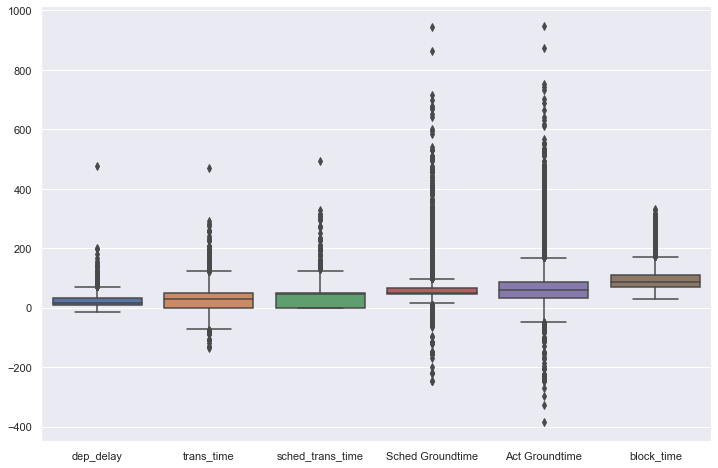

In [30]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.boxplot(data = flt_info.drop(['leg_no'], axis = 1))

# Todo: Check negative ground time 



## Negative Ground Time Check

In [31]:
# 22APR: This cell is partially irrelevant as we remove dupes already at the beginning

# Excel analysis shows that many negative scheduled groundtimes are duplicate leg_no.
# Duplicate removal 
#flt_info_2_removed_dupes_leg_no = flt_info.drop_duplicates(subset = ['leg_no'], keep = False) #for the moment, we remove the duplicates completely as they are not many and we cannot say which one is correct.
#flt_info = flt_info_2_removed_dupes_leg_no

# 22APR: Note: if you reactivate these lines, save the removed rows, not the df
# save changed dataframe
#flt_info_2_removed_dupes_leg_no.to_csv(
#    path_or_buf = '../data/interim/flt_info_2_removed_dupes_leg_no.csv')

# And we see, the negative values reduce. 
#sns.set(rc={'figure.figsize':(12, 8)})
#sns.boxplot(data = flt_info.drop(['leg_no'], axis = 1))

flt_info.describe()

# looking at the remaining values, we see some rotational mismatches


 


,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,block_time
count,1.201700e+04,12017.000000,12017.000000,12017.000000,10004.000000,9942.000000,11934.000000
mean,2.720514e+08,25.782558,27.725139,34.985021,62.837865,66.549789,94.795039
std,9.583346e+04,25.641251,31.900547,31.507227,56.174341,70.686529,41.624100
min,2.719556e+08,-14.000000,-134.000000,0.000000,-245.000000,-383.000000,28.000000
25%,2.719825e+08,9.000000,0.000000,0.000000,45.000000,33.000000,68.000000
50%,2.720115e+08,17.000000,28.000000,45.000000,50.000000,60.000000,86.000000
75%,2.721016e+08,34.000000,49.000000,50.000000,65.000000,87.000000,110.000000
max,2.723603e+08,476.000000,470.000000,495.000000,945.000000,947.000000,333.000000


Creating indicator for rotational mismatches

In [32]:
# Sorting data frame correctly
flt_info = flt_info.sort_values(by = ['ac_registration', 'm_offblockdt'])

# Create binary column indicating rotational mistakes
flt_info['rot_mismatch'] = np.where(
    flt_info['ac_registration'].shift(1).eq(flt_info['ac_registration']) == True, # Where the registration is the same as the row above
    ~flt_info['arr_ap_sched'].shift(1).eq(flt_info['dep_ap_sched']), # Check whether current arr ap is the same as prev. dep ap | Tilde negates the bool value
    False # Set false in case the registrations are not equal, as then a new ac rotation pattern follows
)

# Create df with only dep_sched_date and ac_registration of rotational mistakes
rot_mistakes = flt_info[flt_info['rot_mismatch'] == True][['dep_sched_date','ac_registration']]

# Exclude full day of aircraft if there is one rotational mismatch
# As a rotational mismatch often causes further mistakes in the following lines, we exclude everything for the moment. By this, we lose 666 observations.
flt_info_3_removed_rot_mistakes = flt_info.merge(rot_mistakes, how = 'outer', on = ['dep_sched_date','ac_registration'], indicator = True) # merge with table of rotational mistakes
print(flt_info_3_removed_rot_mistakes['_merge'].value_counts())
flt_info_3_removed_rot_mistakes = flt_info_3_removed_rot_mistakes[flt_info_3_removed_rot_mistakes['_merge'] == 'left_only'] # Filter out observations occuring in both

# save changed dataframe
flt_info_3_removed_rot_mistakes.to_csv(
    path_or_buf = 'C:/Users/PC Paul/Documents/Dokumente/DATA SCIENCE/Courses/Model_Engineering/Delay-Prediction/data/interim/flt_info_3_removed_rot_mistakes.csv')

flt_info = flt_info_3_removed_rot_mistakes


left_only     11426
both            940
right_only        0
Name: _merge, dtype: int64


,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,block_time
count,1.142600e+04,11426.000000,11426.000000,11426.000000,9508.000000,9453.000000,11352.000000
mean,2.720505e+08,25.571241,27.723875,34.859531,62.925431,66.767270,95.259073
std,9.606288e+04,25.324244,31.384900,31.052929,52.109547,66.725589,41.443867
min,2.719556e+08,-14.000000,-133.000000,0.000000,-120.000000,-383.000000,28.000000
25%,2.719820e+08,9.000000,0.000000,0.000000,45.000000,34.000000,69.000000
50%,2.720105e+08,17.000000,28.000000,45.000000,50.000000,60.000000,87.000000
75%,2.721014e+08,34.000000,49.000000,50.000000,65.000000,87.000000,110.000000
max,2.723599e+08,476.000000,274.000000,330.000000,945.000000,947.000000,333.000000


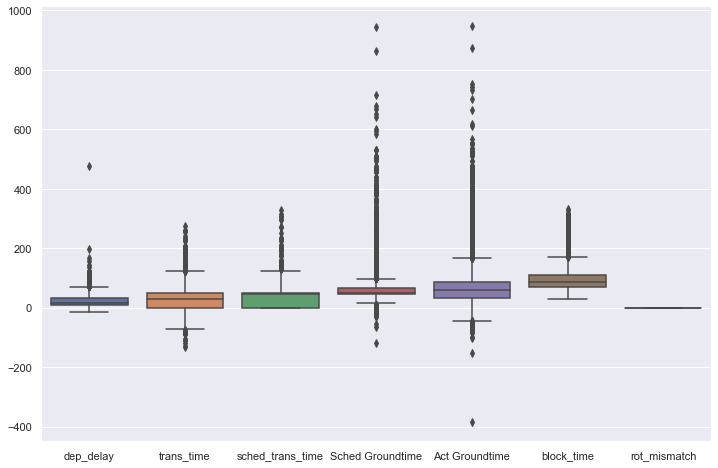

In [33]:
# Rechecking the outliers

sns.set(rc={'figure.figsize':(12, 8)})
sns.boxplot(data = flt_info.drop(['leg_no'], axis = 1))
flt_info.describe()

In [34]:
# We still see many negative values for Sched and Act Groundtime.. 

TH5: Groundtime reliability differs per A/C Registration

In [35]:
flt_info['Neg_Sched_Groundtime'] = np.where(flt_info['Sched Groundtime']<0,'Yes','No')
flt_info['Neg_Act_Groundtime'] = np.where(flt_info['Act Groundtime']<0,'Yes','No')
print(flt_info['Neg_Sched_Groundtime'].value_counts(), "\n")
print(flt_info['Neg_Act_Groundtime'].value_counts())

# We see that act groundtime has many more negative values than sched groundtime
flt_info.columns

No     11410
Yes       16
Name: Neg_Sched_Groundtime, dtype: int64 

No     10554
Yes      872
Name: Neg_Act_Groundtime, dtype: int64


Index(['leg_no', 'fn_carrier', 'fn_number', 'dep_ap_sched', 'arr_ap_sched',
       'dep_sched_date', 'dep_sched_time', 'arr_sched_date', 'arr_sched_time',
       'm_offblockdt', 'm_onblockdt', 'ac_registration', 'change_reason_code',
       'dep_delay', 'Ac Type Code', 'trans_time', 'sched_trans_time',
       'Crew Group', 'TLC_trans', 'crew_type_change', 'Sched Groundtime',
       'Act Groundtime', 'block_time', 'leg', 'route', 'rot_mismatch',
       '_merge', 'Neg_Sched_Groundtime', 'Neg_Act_Groundtime'],
      dtype='object')

In [36]:
pd.set_option("display.max_rows", 70)
pd.pivot_table(data = flt_info, values = ['Ac Type Code'], index = ['ac_registration'], columns = ['Neg_Act_Groundtime'], aggfunc = len)

#We see that this hypothesis is true

Ac Type Code      
Neg_Act_Groundtime           No   Yes
ac_registration                      
ECLBAX                    152.0   NaN
ECLBBX                    130.0  28.0
ECLBCX                    120.0  26.0
ECLBDX                    138.0   1.0
ECLBEX                    157.0   2.0
ECLBFX                    134.0   NaN
ECLBIX                    164.0   1.0
ECLBJX                    145.0   2.0
ECLBKX                    135.0  29.0
ECLBLX                    142.0  40.0
ECLBMX                    166.0   1.0
ECLBNX                    116.0  35.0
ECLBOX                    106.0  23.0
ECLBPX                    151.0  26.0
ECLBQX                    161.0   NaN
ECLBRX                    154.0   2.0
ECLBSX                    165.0   1.0
ECLBTX                    160.0   1.0
ECLBUX                    155.0   NaN
ECLBVX                    134.0  37.0
ECLBWX                    172.0   1.0
ECLBXX                    167.0   1.0
ECLBYX                    186.0   1.0
ECLBZX                    167.0   3.0
ECLDAX                    138.0  29.0
ECLDBX                    147.0   3.0
ECLDCX                    181.0   2.0
ECLDDX                    164.0   NaN
ECLDEX                    158.0   4.0
ECLDFX                    168.0   3.0
ECLDGX                    121.0  32.0
ECLGAX                    171.0  10.0
ECLGBX                    125.0  26.0
ECLGCX                    133.0   7.0
ECLGEX                      8.0   NaN
ECLGFX                    147.0  10.0
ECLGGX                    146.0   9.0
ECLGHX                    151.0   9.0
ECLGIX                    174.0  10.0
ECLGJX                    182.0   8.0
ECLGKX                    146.0   8.0
ECLGLX                    182.0  14.0
ECLGMX                    120.0   7.0
ECLGNX                     33.0   2.0
ECLGOX                    134.0   6.0
ECLGPX                    137.0  10.0
ECLGQX                     66.0  18.0
ECLGRX                    115.0  33.0
ECLWAX                    197.0   2.0
ECLWBX                    156.0  35.0
ECLWCX                    189.0   1.0
ECLWDX                    181.0   NaN
ECLWEX                    179.0   3.0
ECLWFX                    158.0  34.0
ECLWGX                    180.0   2.0
ECLWHX                    174.0   3.0
ECLWIX                    165.0  26.0
ECLWJX                    151.0  30.0
ECLWKX                    131.0  35.0
ECLWLX                    177.0  30.0
ECLWMX                    155.0  37.0
ECLWNX                    134.0  31.0
ECLWOX                    171.0  33.0
ECLWPX                    199.0   2.0
ECLWQX                    186.0   1.0
ECLXAX                    173.0   3.0
ECLXBX                    151.0  38.0
ECLXCX                    172.0   3.0
ECLXDX                    170.0   1.0
ECLXEX                    181.0   1.0

Hypothesis 4: Time of day has influence on dep delay

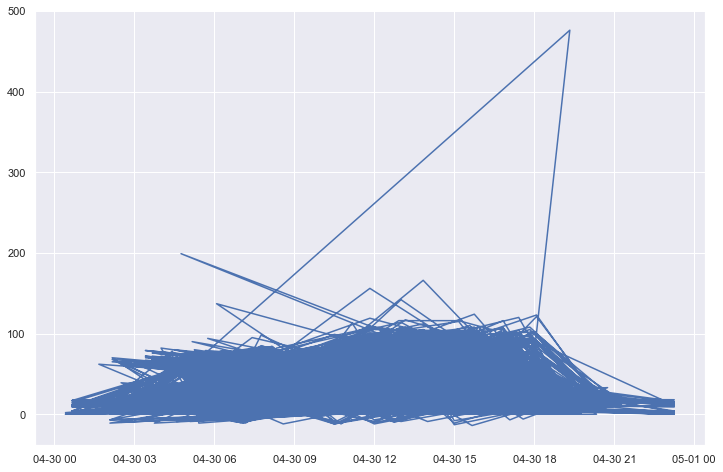

In [37]:
#creade new df
flt_info_h4 = flt_info
flt_info_h4['dep_sched_time_of_day'] = flt_info_h4['dep_sched_time'].dt.time

#workaroud to create time of day with unique date as datetime
dep_sched_time_of_day_datetime = [datetime.datetime.combine(datetime.date.today(), t) for t in flt_info_h4['dep_sched_time_of_day']]
plt.plot(dep_sched_time_of_day_datetime, flt_info_h4['dep_delay'])

#flt_info_h4['dep_sched_time_of_day'] = flt_info_h4['dep_sched_time_of_day'].dt.minute
#flt_info_h4.set_index('dep_sched_time_of_day', inplace = True)



#groupby
#flt_info_h4.groupby('dep_sched_time_of_day').mean()

#plt.plot(flt_info_h4['dep_delay'])

#flt_info['dep_sched_time'].dt.time
#flt_info_h4['dep_sched_time_of_day']

Questions

! Leg and AC-Type are not sufficient for predictions as observations become too little!

(array([85., 62., 30., 33.,  8.,  7., 11.,  6.,  9., 16., 13., 10., 12.,
         8.,  2.,  0.,  6.,  3.,  3.,  4.,  4.,  4.,  7.,  4.,  6.,  5.,
         1.,  1.,  2.,  2.,  2.,  4.,  1.,  5.,  2.,  1.,  3.,  2.,  0.,
         0.,  3.,  2.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,
         4.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         4.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  0.,
         0.,  2.]),
 array([  1.   ,   3.275,   5.55 ,   7.825,  10.1  ,  12.375,  14.65 ,
         16.925,  19.2  ,  21.475,  23.75 ,  26.025,  28.3  ,  30.575,
         32.85 ,  35.125,  37.4  ,  39.675,  41.95 ,  44.225,  46.5  ,
         48.775,  51.05 ,  53.325,  55.6  ,  57.875,  60.15 ,  62.425,
         64.7  ,  66.975,  69.25 ,  71.525,  73.8  ,  76.075,  78.35 ,
         80.625,  82.9  ,  85.175,  87.45 ,  89.725,  92.   ,  94.275,
         96.55 ,  98.825, 101.1  , 103.375, 105.65 , 107.925, 110.2  ,
        112.475, 114.75 , 117.025, 119.3  , 1

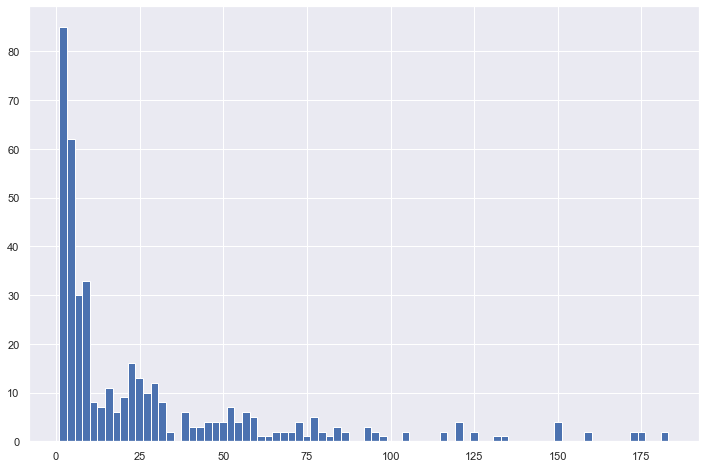

In [38]:
flt_info_solution = flt_info.groupby(['Ac Type Code','leg']).size().reset_index().sort_values(by = [0])
plt.hist(flt_info_solution[0], bins = 80)


In [39]:
leg_test = flt_info[flt_info["route"] == 'East Carmen-West Jason']
#sns.catplot(x=leg_test['leg'], y = leg_test['block_time'], data = leg_test)
#leg_test

In [40]:
flt_info['Ac Type Code'].value_counts()

320    5881
E95    3188
DH4    2357
Name: Ac Type Code, dtype: int64

 # Ground Info

In [41]:
# Ground Info Dataset
ground_info.head()

,day_of_origin,ac_type,fn_number,ac_registration,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration
0,2019-06-01,DH4,EC3114,ECLGNX,35,East Melissaberg,East Carmen,Keithberg,2019-06-01 02:30:00,2019-06-01 04:15:00,2019-06-01 04:50:00,2019-06-01 05:40:00,35,272006092,272205857,26,NaN,26.0
1,2019-06-01,320,EC3316,ECLBIX,40,East Latashaview,East Carmen,Juliemouth,2019-06-01 03:15:00,2019-06-01 07:05:00,2019-06-01 07:50:00,2019-06-01 12:05:00,45,272027070,272029306,27,NaN,15.0
2,2019-06-01,321,EC3292,ECLBAX,45,New Jessica,East Carmen,South Nathaniel,2019-06-01 03:25:00,2019-06-01 06:45:00,2019-06-01 08:20:00,2019-06-01 10:35:00,95,272024970,272022230,27,NaN,25.0
3,2019-06-01,E95,EC3420,ECLWFX,40,East Allisontown,East Carmen,Yoderburgh,2019-06-01 04:00:00,2019-06-01 04:35:00,2019-06-01 05:30:00,2019-06-01 07:05:00,55,272034482,271961698,18,NaN,11.0
4,2019-06-01,DH4,EC3400,ECLGBX,30,Port Courtneytown,East Carmen,West Ana,2019-06-01 04:00:00,2019-06-01 04:35:00,2019-06-01 05:10:00,2019-06-01 07:10:00,35,272033720,271984663,15,NaN,12.0


In [42]:
ground_info.describe()

,mingt,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration
count,4173.000000,4173.000000,4.173000e+03,4.173000e+03,4173.000000,3.000000,3769.000000
mean,39.110951,56.080757,2.720592e+08,2.720428e+08,21.959262,21.505556,18.461926
std,3.267831,17.056430,9.876997e+04,9.305571e+04,4.325588,10.667400,11.926491
min,30.000000,-120.000000,2.719558e+08,2.719560e+08,15.000000,14.000000,0.000000
25%,40.000000,45.000000,2.719893e+08,2.719841e+08,18.000000,15.400000,13.000000
50%,40.000000,55.000000,2.720152e+08,2.720086e+08,22.000000,16.800000,17.000000
75%,40.000000,65.000000,2.721835e+08,2.720336e+08,26.000000,25.258333,22.000000
max,45.000000,100.000000,2.723601e+08,2.723580e+08,29.000000,33.716667,491.000000


In [43]:
ground_info.dtypes

day_of_origin            datetime64[ns]
ac_type                          object
fn_number                        object
ac_registration                  object
mingt                             int64
dep_leg_inbound                  object
arr_leg_inbound                  object
arr_leg_outbound                 object
sched_inbound_dep        datetime64[ns]
sched_inbound_arr        datetime64[ns]
sched_outbound_dep       datetime64[ns]
sched_outbound_arr       datetime64[ns]
sched_turnaround                  int64
leg_inbound                       int64
leg_outbound                      int64
catering_duration                 int64
cleaning_duration               float64
pax_boarding_duration           float64
dtype: object

## Merged Dataset

In [44]:
#Interim: We drop NAs

#flt_info = flt_info.dropna()

In [45]:
# We do a merge of both datasets before engineering flt_info

#pd.set_option("display.max_columns", 101)
#df = pd.merge(flt_info_raw, ground_info, left_on = ['fn_number', 'dep_sched_date'], right_on = ['fn_number','day_of_origin'], how = 'left')
#df.head()



NameError: name 'flt_info_raw' is not defined

<AxesSubplot:>

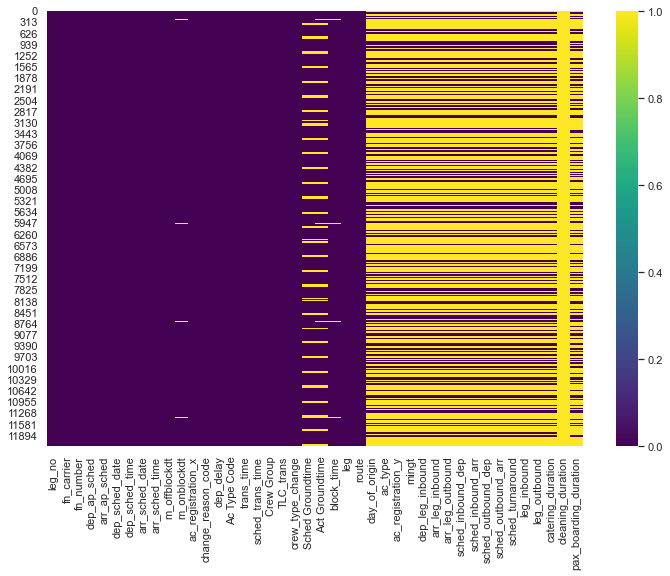

In [ ]:
#sns.heatmap(df.isna(), cmap = 'viridis' )

In [ ]:
df_interim = df
df_interim.to_csv(path_or_buf = 'C:/Users/PC Paul/Documents/Dokumente/DATA SCIENCE/Courses/Model_Engineering/Delay-Prediction/data/interim/df_interim.csv')

